# Import necessary libraries


In [7]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import nltk
import warnings
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import urllib
import matplotlib.pyplot as plt
import requests
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Load 

In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/test.csv')


# Cleaned Tweets

In [5]:
def remove_pattern(text, pattern):
    r = re.findall(pattern, text)
    for i in r:
        text = re.sub(i, "", text)
    return text

combined_data = pd.concat([train, test], ignore_index=True, sort=True)
combined_data['Cleaned_Tweets'] = np.vectorize(remove_pattern)(combined_data['tweet'], "@[\w]*")
combined_data['Cleaned_Tweets'] = combined_data['Cleaned_Tweets'].str.replace("[^a-zA-Z#]", " ")
combined_data['Cleaned_Tweets'] = combined_data['Cleaned_Tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
# Tokenize and stem tweets
tokenized_tweets = combined_data['Cleaned_Tweets'].apply(lambda x: x.split())
ps = nltk.PorterStemmer()
tokenized_tweets = tokenized_tweets.apply(lambda x: [ps.stem(i) for i in x])
for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])
combined_data['Clean_Tweets'] = tokenized_tweets


# ROC Curve


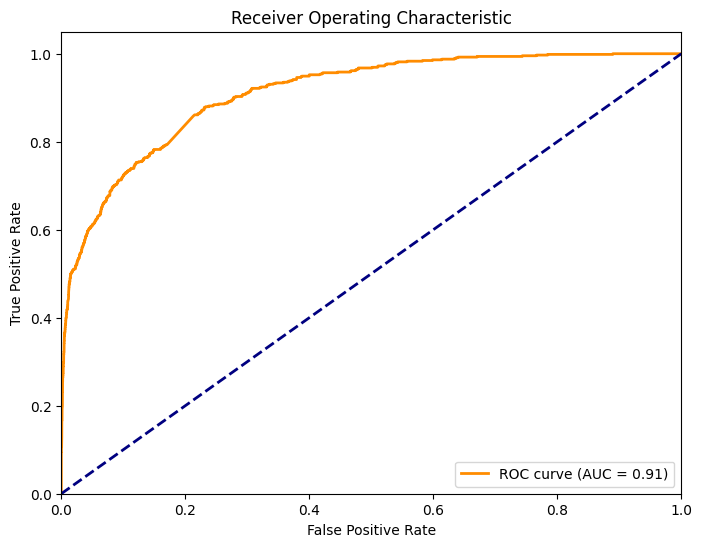

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_valid_tfidf, predict_tfidf[:, 1])
roc_auc = roc_auc_score(y_valid_tfidf, predict_tfidf[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Bar Chart of Label Distribution

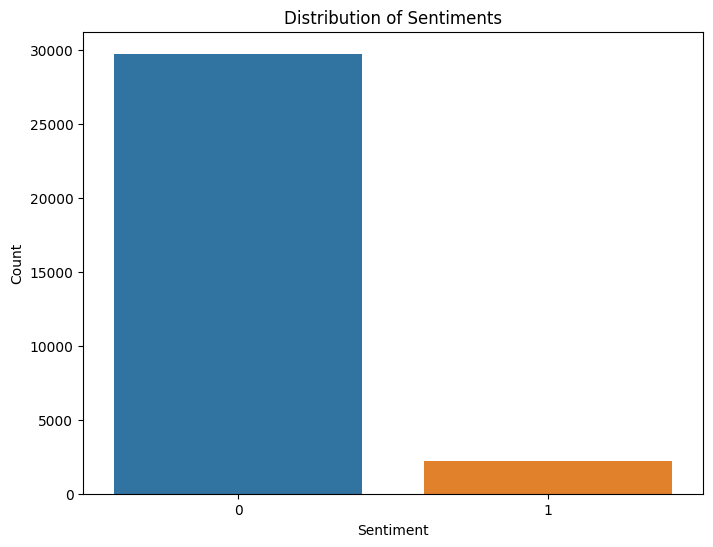

In [21]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
plt.show()


# Histogram of Tweet Lengths

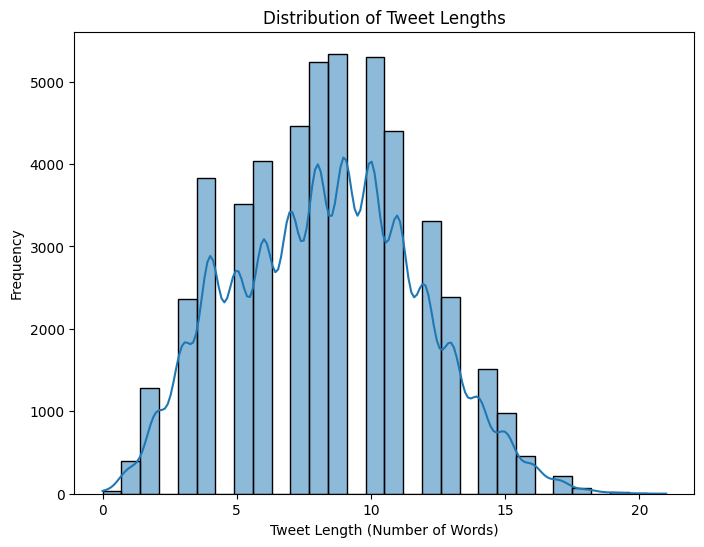

In [22]:
combined_data['tweet_length'] = combined_data['Cleaned_Tweets'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(combined_data['tweet_length'], bins=30, kde=True)
plt.xlabel('Tweet Length (Number of Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Lengths')
plt.show()


# Confusion Matrix

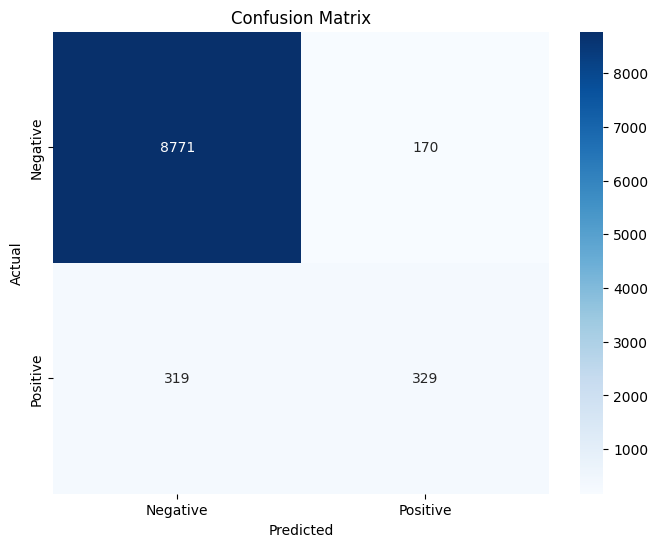

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_valid_tfidf, prediction_int)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Extract hashtags


In [10]:
def extractHashtags(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

positive_hashTags = extractHashtags(combined_data['Cleaned_Tweets'][combined_data['label'] == 0])
positive_hastags_unnested = sum(positive_hashTags, [])
negative_hashtags = extractHashtags(combined_data['Cleaned_Tweets'][combined_data['label'] == 1])
negative_hashtags_unnest = (sum(negative_hashtags, []))


# Visualize top hashtags


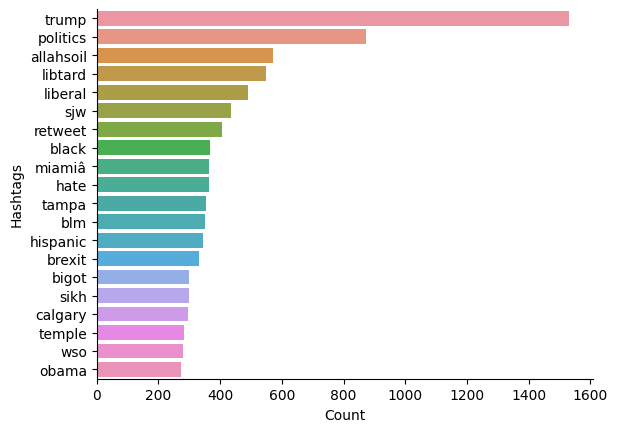

In [11]:
positive_word_freq = nltk.FreqDist(positive_hastags_unnested)
positive_df = pd.DataFrame({'Hashtags': list(positive_word_freq.keys()), 'Count': list(positive_word_freq.values())})
positive_df_plot = positive_df.nlargest(20, columns='Count')
sns.barplot(data=positive_df_plot, y='Hashtags', x='Count')
sns.despine()
negative_word_freq = nltk.FreqDist(negative_hashtags_unnest)
negative_df = pd.DataFrame({'Hashtags': list(negative_word_freq.keys()), 'Count': list(negative_word_freq.values())})
negative_df_plot = negative_df.nlargest(20, columns='Count')
sns.barplot(data=negative_df_plot, y='Hashtags', x='Count')
sns.despine()

# Feature Extraction

In [12]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words="english")
bow = bow_vectorizer.fit_transform(combined_data['Cleaned_Tweets'])

# Create a DataFrame from Bag of Words (BoW) features
bow_df = pd.DataFrame(bow.todense())

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_data['Cleaned_Tweets'])

tfidf_df = pd.DataFrame(tfidf_matrix.todense())

# Split data

In [14]:
train_bow = bow[:31962]
train_tfidf_matrix = tfidf_matrix[:31962]

# Split the data further into training and validation sets
x_train_bow, x_valid_bow, y_train_bow, y_valid_bow = train_test_split(train_bow, train['label'], test_size=0.3, random_state=2)
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(train_tfidf_matrix, train['label'], test_size=0.3, random_state=17)

# Logistic Regression model

In [15]:
log_Reg = LogisticRegression(random_state=0, solver='lbfgs')
log_Reg.fit(x_train_bow, y_train_bow)

# Predict on validation data
predict_bow = log_Reg.predict_proba(x_valid_bow)
prediction_int = predict_bow[:, 1] >= 0.3
prediction_int = prediction_int.astype(int)


# f1 score

In [18]:
log_bow = f1_score(y_valid_bow, prediction_int)

log_Reg.fit(x_train_tfidf, y_train_tfidf)

# Predict on validation data
predict_tfidf = log_Reg.predict_proba(x_valid_tfidf)
prediction_int = predict_tfidf[:, 1] >= 0.3
prediction_int = prediction_int.astype(int)

# Calculate f1 score for TF-IDF
log_tfidf = f1_score(y_valid_tfidf, prediction_int)

# Predict on test data using TF-IDF
test_tfidf = tfidf_matrix[31962:]
test_pred = log_Reg.predict_proba(test_tfidf)
test_pred_int = test_pred[:, 1] >= 0.3
test_pred_int = test_pred_int.astype(int)
print("F1 Score for Bag of Words (BoW) Model:", log_bow)
print("F1 Score for TF-IDF Model:", log_tfidf)


F1 Score for Bag of Words (BoW) Model: 0.056027164685908314
F1 Score for TF-IDF Model: 0.5736704446381866


In [17]:
test['label'] = test_pred_int

submission = test[['id', 'label']]
submission.to_csv('result.csv', index=False)

res = pd.read_csv('result.csv')
res

,id,label
0,31963,0
1,31964,1
2,31965,0
3,31966,0
4,31967,0
...,...,...
17192,49155,1
17193,49156,0
17194,49157,0
17195,49158,0
